# Covid in Brazil - NetworkX Graph Tracing

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random

In [2]:
import multiprocess as mp
from itertools import islice

In [3]:
from datetime import datetime, date

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

## Data Preparation

### Some extra functions

In [6]:
def date_diff(d_source,d_target):
    date_format = "%Y-%m-%d"
    a = datetime.strptime(d_source, date_format)
    b = datetime.strptime(d_target, date_format)
    delta = b - a
    return delta.days

In [8]:
def get_date(d):
    date_format = "%Y-%m-%d"
    return datetime.strptime(d,date_format)

### Import cleaned data

In [9]:
df = pd.read_csv("cleaned_data/brazilian_data_en.csv", on_bad_lines="skip")
pd.set_option('display.max_columns', None)

In [10]:
df

,Diagnosis Date,Closing Date,Classification,Evolution,Confirmation Criteria,Status Notification,Position,Age range,Age,Gender,Education Level,Pregnancy,Fever,Respiratory Difficulty,Cough,Coryza,Sore throat,Diarrhoea,CEPHALGIA,ComorbidityLung,ComorbidityCardio,Renal comorbidity,comorbidity diabetes,Comorbidity Smoking,comorbidity obesity,was hospitalized,International trip,professional health,has a disability,Homeless,RT_PCR Result,QuickTestResult
0,2021-04-23,2021-05-05,Confirmed,Cure,Laboratorial,Closed,"('SERRA', 'JARDIM ATLÂNTICO')",60-69,64,M,Complete elementary school,No,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,No,No,No,No,Unknown,Unknown,No,No,No,Unknown,Unknown
1,2021-12-24,2021-12-20,Discarded,Unknown,Laboratorial,Closed,"('PIUMA', 'JARDIM MAILY')",70-79,74,F,Incomplete high school,No,Yes,No,No,No,No,Yes,Yes,No,Yes,No,Yes,No,No,No,No,No,No,No,Negative,Unknown
2,2021-12-21,NaN,Confirmed,Unknown,Laboratorial,Open,"('GUARAPARI', 'ITAPEBUSSU')",40-49,41,F,Complete higher education,No,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No,No,Unknown,No,No,No,No,Unknown,Negative
3,2021-12-23,2020-12-19,Suspect,Unknown,Laboratorial,Closed,"('PIUMA', 'CENTRO')",20-29,22,M,Complete high school,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown
4,2021-12-24,NaN,Suspect,Unknown,Clinic,Open,"('VITORIA', 'BONFIM')",40-49,42,F,Complete high school,No,No,No,Yes,Yes,No,No,Yes,No,No,No,No,No,No,Unknown,Unknown,Yes,No,No,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208172,2020-02-15,2020-04-16,Discarded,Unknown,Laboratorial,Closed,"('VILA VELHA', 'JOCKEY DE ITAPARICA')",30-39,39,F,Unknown,No,Yes,Yes,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,Unknown,Unknown,Negative,Unknown
2208173,2020-02-15,2020-04-16,Discarded,Unknown,Laboratorial,Closed,"('VILA VELHA', 'JOCKEY DE ITAPARICA')",0-4,4,F,Unknown,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,Unknown,No,No,Unknown,Unknown,Negative,Unknown
2208174,2020-02-25,2020-04-15,Discarded,Unknown,Laboratorial,Closed,"('ARACRUZ', 'JEQUITIBÁ')",20-29,25,M,Unknown,No,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,Unknown,Yes,No,Unknown,Unknown,Negative,Unknown
2208175,2020-02-13,2020-04-16,Discarded,Death,Laboratorial,Closed,"('SERRA', 'BAIRRO DE FÁTIMA')",50-59,54,M,Unknown,No,Yes,Yes,Yes,No,Yes,No,No,No,No,No,No,No,No,No,Yes,No,No,No,Negative,Unknown


In [11]:
df = df.loc[df["Pregnancy"] != "Gestational age ignored"]
df = df.drop(['Closing Date',"RT_PCR Result","QuickTestResult"],axis=1)

For testing use only, due to the very long computation times, we limit our dataset to the "VITORIA" state only

In [12]:
ind_drop = []
new_pos = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    x = row["Position"].replace("(","").replace(")","").split(",")[0].replace("'","").strip()
    y = row["Position"].replace("(","").replace(")","").split(",")[1].replace("'","").strip()
    #print(y)
    if x != "VITORIA":
        ind_drop.append(index)
    else:
        new_pos.append(y)
    

  0%|          | 0/2207509 [00:00<?, ?it/s]

In [13]:
df = df.drop(ind_drop).reset_index().drop(columns={"index"})

In [14]:
df["Position"] = new_pos

Now we can select only the "closed" cases (of which we have, therefore, all the information and the outcome) and send the dataset to the encoding function

In [15]:
df_open = df.loc[(df['Status Notification'] == "Open")
                 & (df['Classification'] == "Suspect")].reset_index().drop(['index', 'Evolution',
                                                                      'Confirmation Criteria',
                                                                             'Status Notification'],axis=1)
df_open.shape

(66799, 26)

In [16]:
df_closed = df.loc[(df['Status Notification'] == "Closed")
                   & (df['Classification'] != "Suspect")].reset_index().drop(['index', 'Evolution',
                                                                                'Confirmation Criteria',
                                                                                'Status Notification'],axis=1)
df_closed.shape

(193157, 26)

In [17]:
df_closed

,Diagnosis Date,Classification,Position,Age range,Age,Gender,Education Level,Pregnancy,Fever,Respiratory Difficulty,Cough,Coryza,Sore throat,Diarrhoea,CEPHALGIA,ComorbidityLung,ComorbidityCardio,Renal comorbidity,comorbidity diabetes,Comorbidity Smoking,comorbidity obesity,was hospitalized,International trip,professional health,has a disability,Homeless
0,2021-12-24,Discarded,JARDIM DA PENHA,20-29,25,M,Unknown,No,Yes,No,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,2021-12-11,Discarded,MARIA ORTIZ,10-19,15,F,Unknown,No,No,No,Yes,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No
2,2021-12-21,Discarded,PRAIA DO CANTO,40-49,47,M,Unknown,No,Yes,No,No,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No
3,2021-12-21,Discarded,SEGURANÇA DO LAR,30-39,36,F,Unknown,No,No,No,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No
4,2021-12-21,Discarded,REPÚBLICA,10-19,17,M,Unknown,No,Yes,No,Yes,Yes,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193152,2020-03-05,Discarded,JARDIM DA PENHA,20-29,28,F,Unknown,No,No,No,No,No,Yes,Yes,Yes,No,No,No,No,No,No,Unknown,Unknown,Unknown,Unknown,Unknown
193153,2020-03-05,Discarded,PRAIA DO CANTO,20-29,26,F,Unknown,No,No,No,No,Yes,No,Yes,Yes,No,No,No,No,No,No,Unknown,Unknown,Unknown,Unknown,Unknown
193154,2020-03-06,Discarded,JARDIM DA PENHA,30-39,32,M,Unknown,No,Yes,Yes,No,No,No,No,Yes,No,No,No,No,No,No,Unknown,Yes,Unknown,Unknown,Unknown
193155,2020-02-26,Discarded,JARDIM DA PENHA,0-4,1,M,Unknown,No,Yes,No,Yes,Yes,No,No,No,No,No,No,No,No,No,Unknown,Yes,Unknown,Unknown,Unknown


In [18]:
def encoding_dataset(data):
    dict_pregnancy = {
        "No":0,
        "Unknown":1,
        "1st trimester": 2,
        "2nd trimester": 3,
        "3rd trimester": 4
    }
    dict_education = {
        'Unknown': 0,
        'Illliterate': 1,
        'Incomplete 1st to 4th grade of elementary school': 2,
        '4th grade of elementary school': 3,
        'Incomplete 5th to 8th grade of elementary school': 4,
        'Complete elementary school': 5,
        'Incomplete high school': 6,
        'Complete high school': 7,
        'Incomplete higher education': 8,
        'Complete higher education': 9
    }
    dict_age_range = {
        '0-4': 0,
        '5-9': 1,
        '10-19': 2,
        '20-29': 3,
        '30-39': 4,
        '40-49': 5,
        '50-59': 6, 
        '60-69': 7,
        '70-79': 8,
        '80-89': 9,
        '90-100': 10
    }
    dict_gender = {
        "M":1,
        "F":0
    }
    dict_evolution = {
        "Cure":1,
        "Death":0
    }
    
    data = data.replace({"Evolution":dict_evolution, "Age range":dict_age_range,
                         "Education Level":dict_education, "Pregnancy":dict_pregnancy, "Gender":dict_gender})
    #Add Useful column to the dataset: sum of comorbitites, sum of symptomps
    col_sym = list(data.iloc[:,6:13].columns.values)
    col_com = list(data.iloc[:,13:19].columns.values)
    
    data['sum_comorb'] = (data[col_com] == 'Yes').sum(axis=1)
    data['sum_sym'] = (data[col_sym] == 'Yes').sum(axis=1)
    
    cat_cols = list(data.columns.values)
    cat_cols.remove("Age range")
    cat_cols.remove("Age")
    cat_cols.remove("Education Level")
    cat_cols.remove("Pregnancy")
    cat_cols.remove("Gender")
    cat_cols.remove("Position")
    cat_cols.remove("sum_comorb")
    cat_cols.remove("sum_sym")
    cat_cols.remove("Diagnosis Date")
    cat_cols.remove("Classification")
    cat_cols.remove("Fever")
    cat_cols.remove("Respiratory Difficulty")
    cat_cols.remove("Cough")
    cat_cols.remove("Coryza")
    cat_cols.remove("Sore throat")
    cat_cols.remove("Diarrhoea")
    cat_cols.remove("CEPHALGIA")
    cat_cols.remove("ComorbidityLung")
    cat_cols.remove("ComorbidityCardio")
    cat_cols.remove("Renal comorbidity")
    cat_cols.remove("comorbidity diabetes")
    cat_cols.remove("Comorbidity Smoking")
    cat_cols.remove("comorbidity obesity")
    cat_cols.remove("was hospitalized")
    cat_cols.remove("has a disability")
                

    #Encoding with "get_dummies()" tool in pandas
    data2 = pd.get_dummies(data,columns=cat_cols)
    data2["Age range"] = data["Age range"]
    data2["Education Level"] = data["Education Level"]
    data2["Pregnancy"] = data["Pregnancy"]
    data2['Gender'] = data['Gender']
    data2['sum_comorb'] = data['sum_comorb']
    data2['sum_sym'] = data['sum_sym']
    
    #Apply Standard Scale on the columns below
    col_names = ['Education Level', 'Pregnancy', 'Age range', 'Age']
    features = data2[col_names]
    ct = ColumnTransformer([
        ('somename', StandardScaler(), col_names)
    ], remainder='passthrough')
    data2[col_names] = ct.fit_transform(features)
    
    return data2

In [19]:
df_closed_enc = encoding_dataset(df_closed)

In [20]:
df_closed_enc = df_closed_enc.loc[df_closed_enc["Diagnosis Date"].str.split(pat="-",expand=True)[0] == "2021"]
df_closed_enc = df_closed_enc.loc[df_closed_enc["Diagnosis Date"].str.split(pat="-",expand=True)[1].astype(int) == 11]

In [21]:
df_closed_enc.Classification.value_counts()

Discarded    6849
Confirmed    1273
Name: Classification, dtype: int64

In [22]:
df_closed_enc = df_closed_enc.reset_index().drop(columns={"index"})

In [23]:
col_to_drop = ["Age","Fever","Respiratory Difficulty","Cough","Coryza","Sore throat","Diarrhoea","CEPHALGIA",
               "ComorbidityLung", "ComorbidityCardio", "Renal comorbidity", "comorbidity diabetes",
               "Comorbidity Smoking", "comorbidity obesity", "was hospitalized","has a disability"]
df_closed_enc = df_closed_enc.drop(columns=col_to_drop)

In [24]:
df_closed_enc = df_closed_enc.sort_values(by="Diagnosis Date").reset_index().drop(columns="index")

Our final dataset will be the following, relating to the VITORIA's state in the period from 1 to 30 November 2021

In [25]:
df_closed_enc

,Diagnosis Date,Classification,Position,Age range,Gender,Education Level,Pregnancy,sum_comorb,sum_sym,International trip_No,International trip_Unknown,International trip_Yes,professional health_No,professional health_Unknown,professional health_Yes,Homeless_No,Homeless_Unknown,Homeless_Yes
0,2021-11-01,Discarded,CENTRO,-0.766708,0,0.932243,-0.069648,0,2,1,0,0,1,0,0,1,0,0
1,2021-11-01,Discarded,SANTA LÚCIA,-0.235700,1,1.194125,-0.069648,2,1,1,0,0,1,0,0,1,0,0
2,2021-11-01,Discarded,ITARARÉ,-1.828725,0,-0.639047,-0.069648,0,3,1,0,0,1,0,0,1,0,0
3,2021-11-01,Discarded,JARDIM DA PENHA,-1.297717,1,0.408480,-0.069648,0,3,1,0,0,1,0,0,1,0,0
4,2021-11-01,Discarded,CENTRO,0.826317,0,-1.162810,-0.069648,1,2,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8117,2021-11-30,Discarded,MARIA ORTIZ,-0.766708,0,0.670362,-0.069648,0,0,1,0,0,1,0,0,1,0,0
8118,2021-11-30,Confirmed,MATA DA PRAIA,-0.766708,1,-1.162810,-0.069648,0,1,0,1,0,0,1,0,1,0,0
8119,2021-11-30,Discarded,JARDIM CAMBURI,-0.766708,1,0.932243,-0.069648,0,2,1,0,0,1,0,0,1,0,0
8120,2021-11-30,Discarded,MATA DA PRAIA,-0.235700,0,1.194125,-0.069648,0,0,1,0,0,1,0,0,1,0,0


## Graph Construction

### Create Graph from Edgelist

In [26]:
def func(d):
    edge_list = [] #[source,target,weight] => Elements of the list
    for index,row in tqdm(d.iterrows(), total=d.shape[0]):
        #for index_1,row_1 in tqdm(d.iterrows(), leave=False, total=d.shape[0]):
        if row['Classification'] == 'Confirmed':
            for index_1,row_1 in d.iterrows():
                if index != index_1:
                    diff = date_diff(row['Diagnosis Date'],row_1['Diagnosis Date'])
                    if row["Position"] == row_1["Position"]:
                        if diff == -1:
                            edge_list.append([index,index_1,4])
                        elif diff == -2:
                            edge_list.append([index,index_1,3])
                    else:
                        if diff == -1:
                            edge_list.append([index,index_1,2])
                        elif diff == -2:
                            edge_list.append([index,index_1,1])
    return edge_list

In [27]:
#confirmed_cases = df_closed_enc.loc[df_closed_enc["Classification"] == "Confirmed"].reset_index().drop(columns={"index"})
ret = func(df_closed_enc)

  0%|          | 0/8122 [00:00<?, ?it/s]

In [28]:
edges = pd.DataFrame(ret, columns = ['edge_source', 'edge_target','edge_dist_prob'])
edges

,edge_source,edge_target,edge_dist_prob
0,236,0,2
1,236,1,2
2,236,2,2
3,236,3,2
4,236,4,2
...,...,...,...
649958,8118,7790,2
649959,8118,7791,2
649960,8118,7792,2
649961,8118,7793,4


In [29]:
G = nx.from_pandas_edgelist(edges, "edge_source", "edge_target", "edge_dist_prob")

### Set node and edges attributes in the Graph

In [30]:
nx.set_node_attributes(G, df_closed_enc['Diagnosis Date'].to_dict(), 'node_date')
nx.set_node_attributes(G, df_closed_enc['Position'].to_dict(), 'node_type')
nx.set_node_attributes(G, df_closed_enc['Classification'].to_dict(), 'node_label')
nx.set_node_attributes(G, pd.Series(df_closed_enc.iloc[:,3:].values.tolist()).to_dict(), 'node_features')

In [31]:
nx.info(G)

'Graph with 7832 nodes and 649963 edges'

In [32]:
edges_attr = {}
for node, attr in G.nodes(data=True):
    edges_attr[node] = [0,0]
#for u, v, attr in G.edges(data=True):
len(edges_attr)

7832

In [33]:
for node, attr in G.nodes(data=True):
    ns = G.neighbors(node)
    pos = 0
    neg = 0
    for n in ns:
        if G.nodes[n]['node_label'] == "Confirmed":
            pos += 1
        elif G.nodes[n]['node_label'] == "Discarded":
            neg += 1
    edges_attr[node] = [pos, neg]

In [34]:
for s, d, attr in G.edges(data=True):
    G[s][d]["edge_weight"] = 0
    G[s][d]["edge_type"] = ""

In [35]:
#edge types: e = equal city, d = disequal city
for s, d, attr in G.edges(data=True):
    G[s][d]["edge_prob"] = edges_attr[s][0] / (edges_attr[s][0] + edges_attr[s][1])
    G[s][d]["edge_weight"] += G[s][d]["edge_prob"] * G[s][d]["edge_dist_prob"]
    if G.nodes[s]['node_type'] == G.nodes[d]['node_type']:
        G[s][d]["edge_type"] == "e"
    else:
        G[s][d]["edge_type"] == "d"

In [36]:
for s, d, attr in G.edges(data=True):
    G[s][d]["edge_weight"] = 1 / G[s][d]["edge_weight"]

In [37]:
print("Number of nodes: %d" % G.number_of_nodes())
print("Number of edges: %d" % G.number_of_edges())
print("Number of connected components: %d" % nx.number_connected_components(G))

Number of nodes: 7832
Number of edges: 649963
Number of connected components: 1


## Print Graph

In [82]:
color_map = []
for node, attr in G.nodes(data=True):
    if attr['node_label'] == 'Confirmed':
        color_map.append('red')
    else: 
        color_map.append('green')

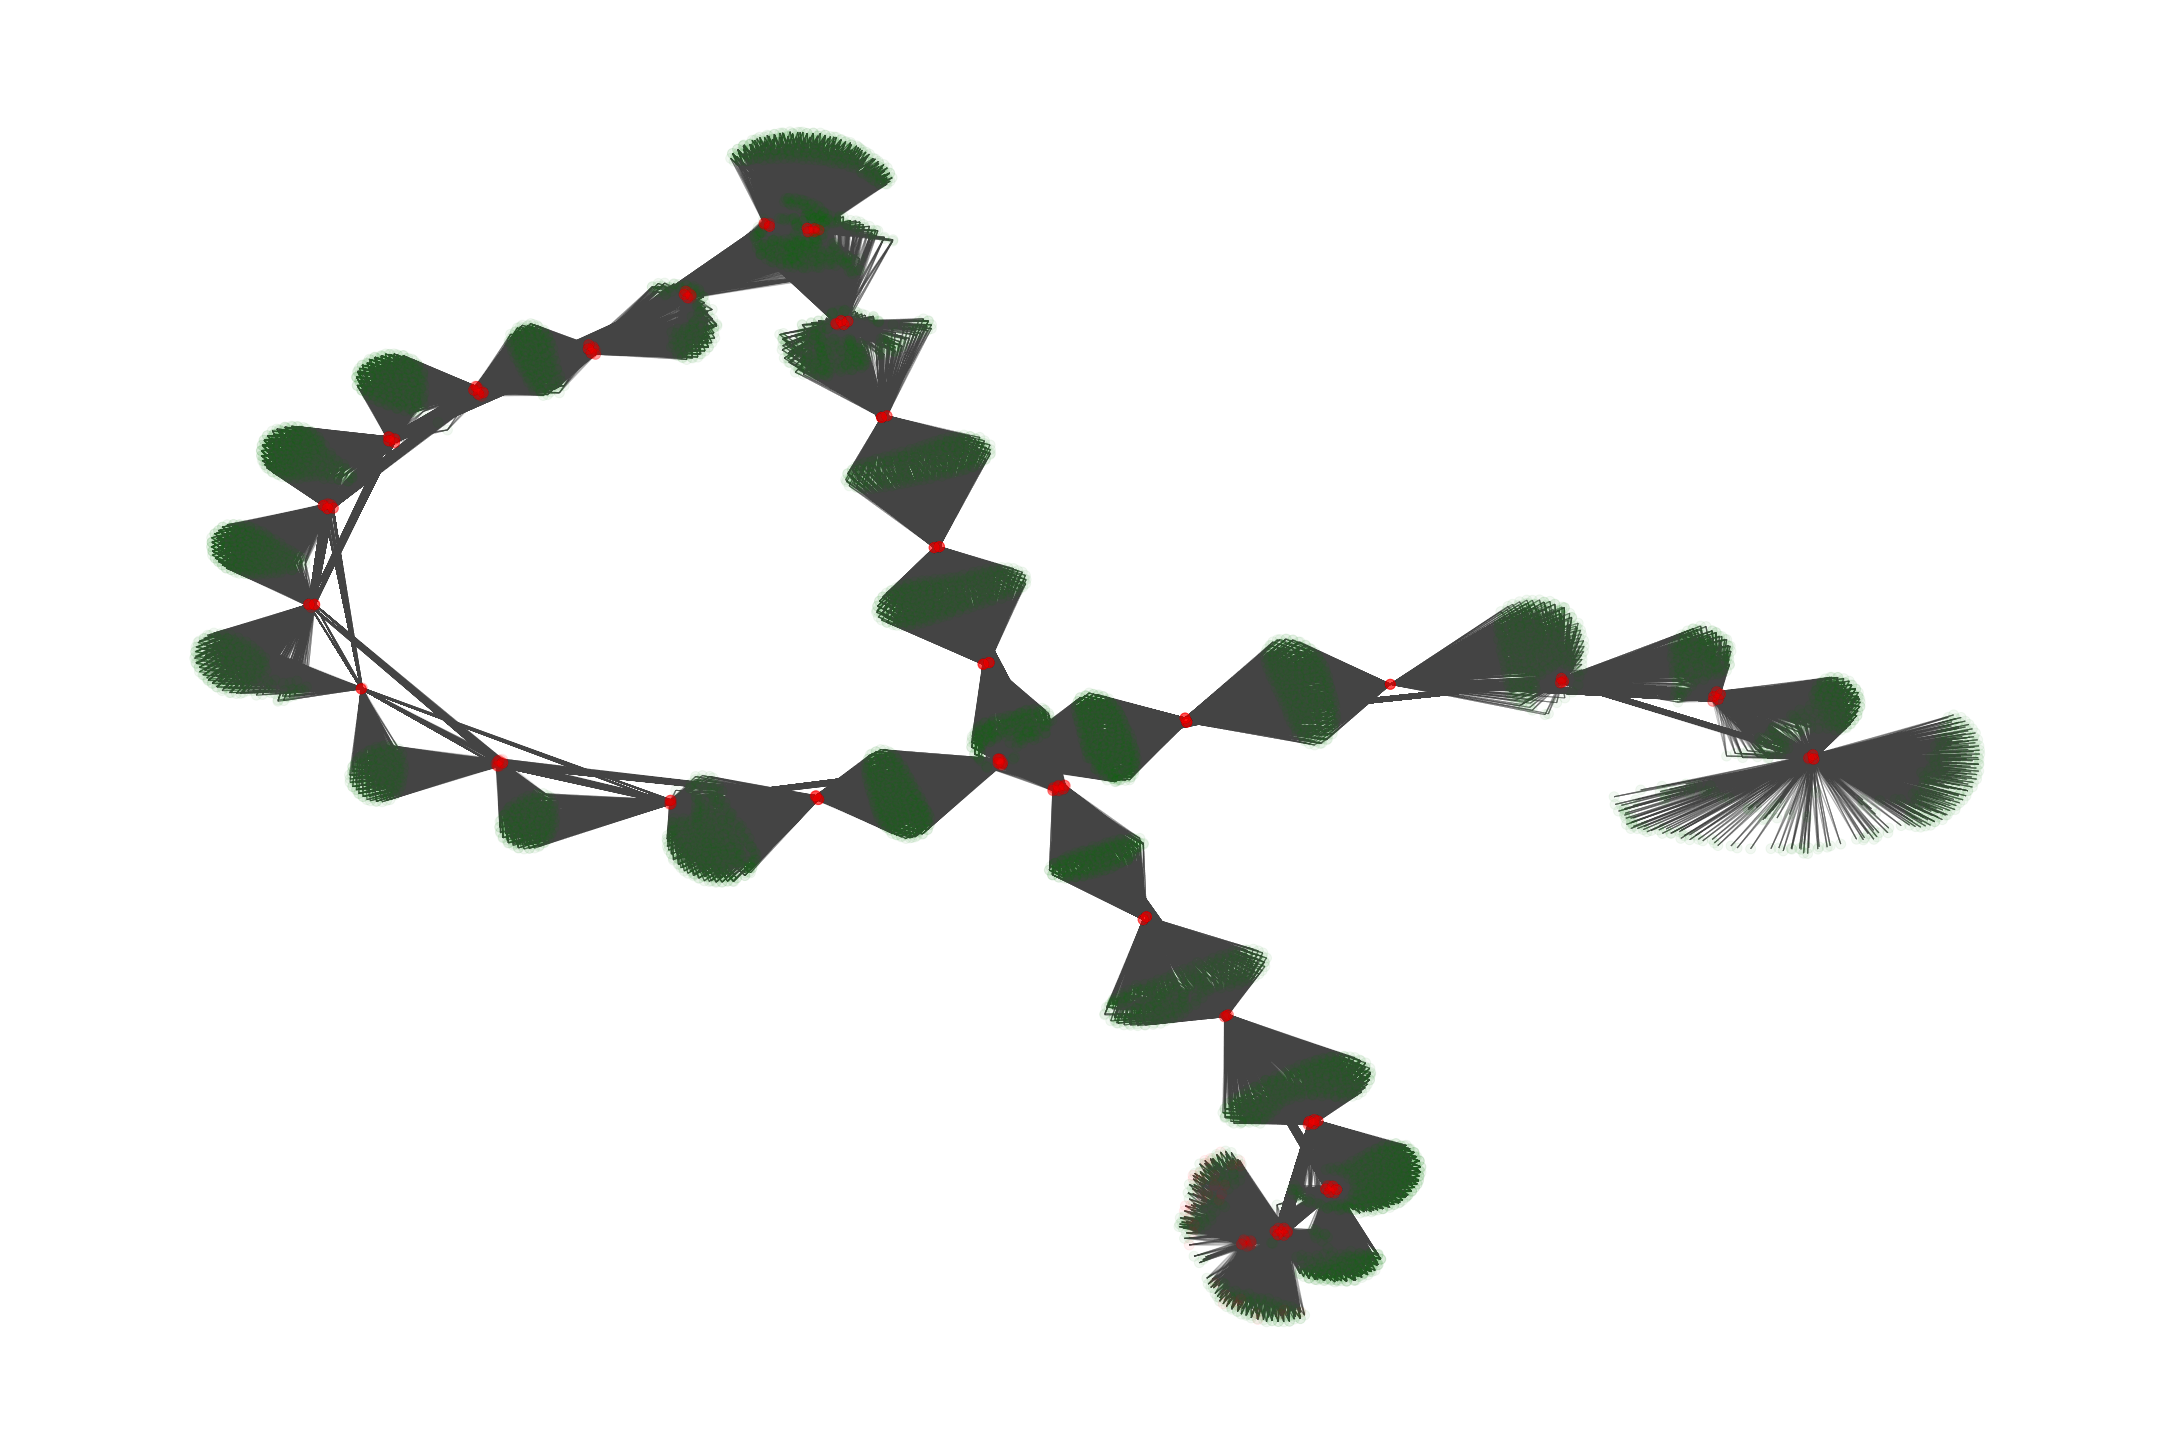

In [98]:
#nx.draw(G, node_color=color_map)
pos = nx.spring_layout(G, k=0.1)
plt.rcParams.update({'figure.figsize': (30, 20)})
nx.draw(
    G,
    pos=pos,
    node_size=100,
    edge_color="#444444",
    node_color=color_map,
    alpha=0.05,
    with_labels=False)

## Communities detection in graph

In [84]:
from networkx.algorithms.community import greedy_modularity_communities
k = 1
comp = community.greedy_modularity_communities(G, weight="edge_weight")
len(comp)

3

In [91]:
color_map_2 = []
color=["red","green","blue","violet"]
st = 0
for fz in comp:
    for node, attr in G.nodes(data=True):
        if node in fz:
            color_map_2.append(color[st])
    st += 1

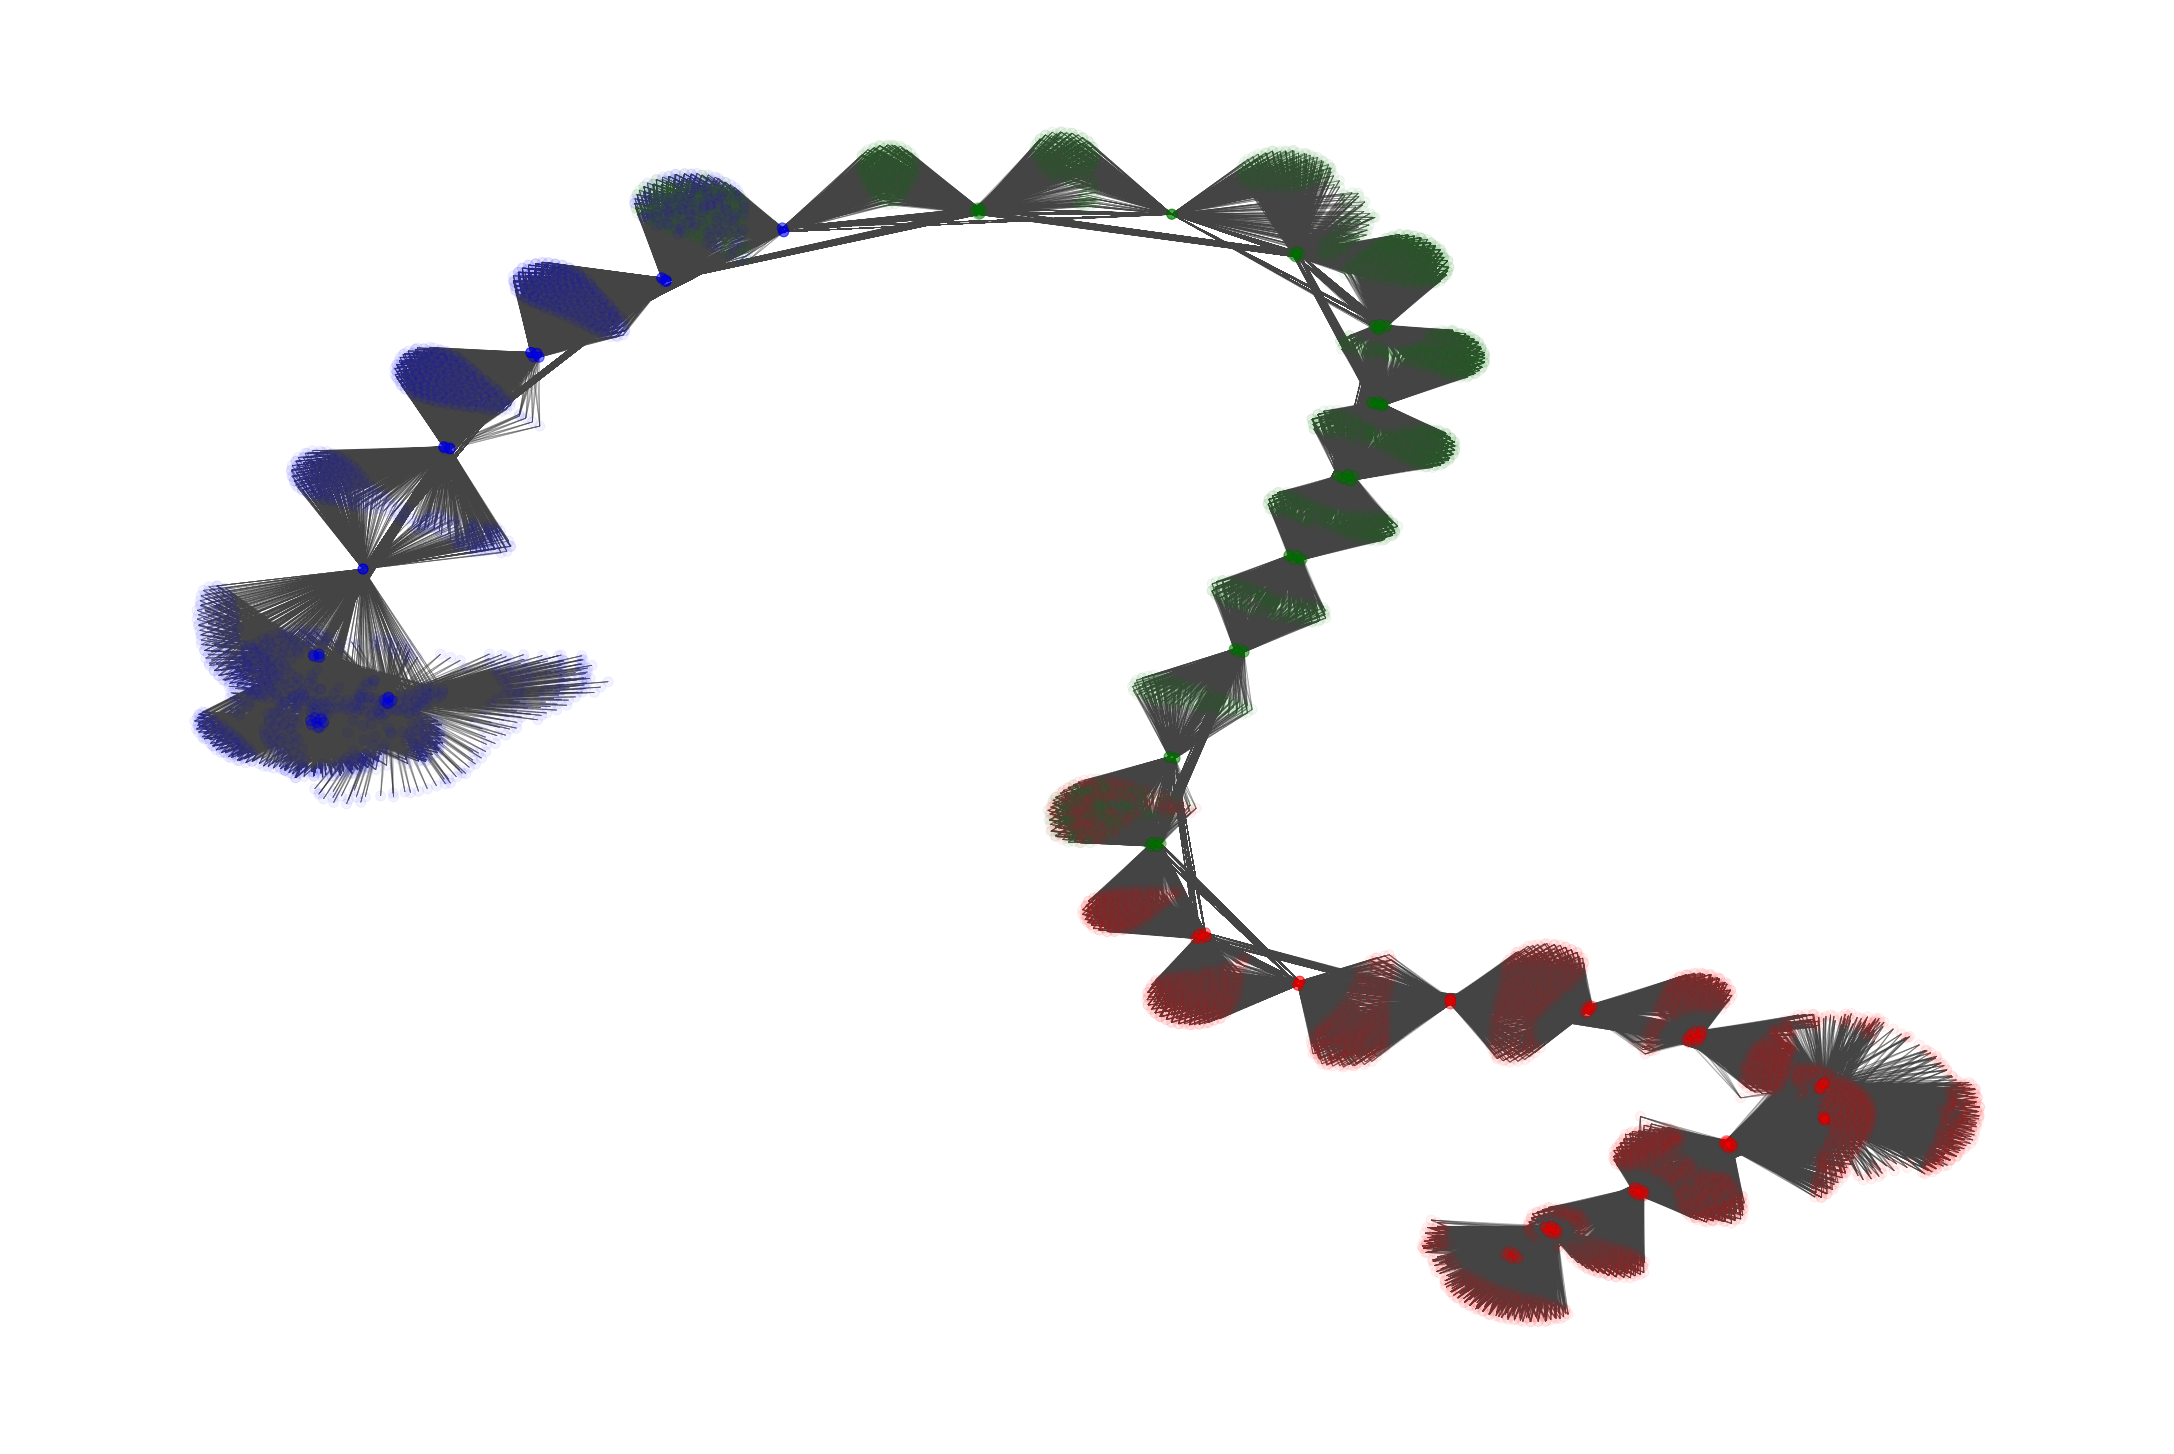

In [99]:
pos = nx.spring_layout(G, k=0.1)
plt.rcParams.update({'figure.figsize': (30, 20)})
nx.draw(
    G,
    pos=pos,
    node_size=100,
    width=0.75,
    edge_color="#444444",
    node_color=color_map_2,
    alpha=0.05,
    with_labels=False)

As we can see from the graph drawn above, mainly 3 periods are detected during our testing month.

It is possible to notice how the pattern is very repetitive also in the colors and in the shape, making us understand that the contagion patterns are quite repetitive.

In the graph there are areas where the clusters tend to mix or thicken, this could mean two things:
- There are new positivity coming into play from the outside (other states / trips ...)
- The areas of greatest density are related to larger epidemiological clusters